In [3]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import json
import numpy as np
import jax
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from timecast.learners import AR
from timecast.learners._ar import _ar_predict, _ar_batch_window
from timecast.utils.numpy import ecdf
from timecast.utils.losses import MeanSquareError
import torch
import matplotlib

plt.rcParams['figure.figsize'] = [20, 10]

import tqdm.notebook as tqdm

/home/dsuo/miniconda3/envs/toy_flood/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Training

In [5]:
!python ../ealstm/main.py train --camels_root ../data/basin_dataset_public_v1p2 --num_workers 50 --cache_data True

device: cuda:0
mode: train
camels_root: ../data/basin_dataset_public_v1p2
seed: 215785
run_dir: None
cache_data: True
num_workers: 50
no_static: False
concat_static: False
use_mse: False
batch_size: 256
clip_norm: True
clip_value: 1
dropout: 0.4
epochs: 30
hidden_size: 256
initial_forget_gate_bias: 5
log_interval: 50
learning_rate: 0.001
seq_length: 270
train_start: 1999-10-01 00:00:00
train_end: 2008-09-30 00:00:00
val_start: 1989-10-01 00:00:00
val_end: 1999-09-30 00:00:00
Sucessfully stored basin attributes in /home/dsuo/src/toy_flood/notebooks/../ealstm/runs/run_2803_1428_seed215785/attributes.db.
# Epoch 30: 100%|███████████| 6821/6821 [15:58<00:00,  7.11it/s, Loss: 0.012212]


# Evaluation

In [1]:
!python ../ealstm/main.py evaluate --camels_root ../data/basin_dataset_public_v1p2 --run_dir ../ealstm/runs/run_2803_1428_seed215785/

100%|█████████████████████████████████████████| 531/531 [05:10<00:00,  1.71it/s]
Sucessfully store results at ../ealstm/runs/run_2803_1428_seed215785/ealstm_seed215785.p


In [7]:
data = pickle.load(open("../ealstm/runs/run_2803_1428_seed215785/ealstm_seed215785.p", "rb"))

In [8]:
results = {"mse": {}, "count": {}}
for key, site in data.items():
    results["mse"][key] = MeanSquareError().compute(site.qobs, site.qsim)
    results["count"][key] = site.shape[0]

In [9]:
def total_mse(results):
    mse = 0
    count = 0
    for key in results["mse"].keys():
        mse += results["mse"][key] * results["count"][key]
        count += results["count"][key]
    return mse / float(count)

In [10]:
total_mse(results)

DeviceArray(3.4499993, dtype=float32)

In [20]:
def plot_ecdf(learners):
    for key, learner in learners.items():
        x = np.array([val.item() for key, val in learner["mse"].items()])
        bin_, cdf_ = ecdf(x)
        plt.plot(bin_, cdf_, label=key)
    plt.legend()

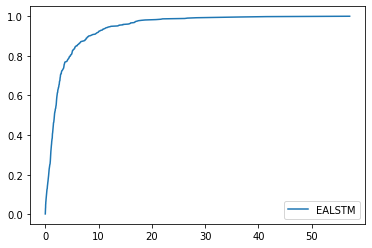

In [21]:
plot_ecdf({"EALSTM": results})

In [13]:
plt.xlim??